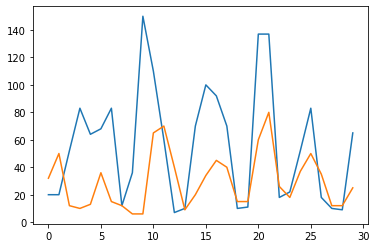

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error

# Ignore integration and solver convergence warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

feature_names = ['x', 'y']

dt = 2
t_train = np.arange(1845,1903+dt,dt) 
t_test = np.arange(1845,1845+6+dt,dt) 


SH = np.array([20,20,52,83,64,68,83,12,36,150,110,60,7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65])
CL = np.array([32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25])
X = np.zeros((len(SH),2))
X[:,0] = SH
X[:,1] = CL

#t_train = np.arange(0,len(SH),1)
#t_test = t_train

x_0 = X[0,:]

x_train = X
x_test = X
plt.figure()
plt.plot(x_test)


In [2]:
functions = [
             lambda x: x*x,
             lambda y: y*y,
             lambda x,y : x*x*y,
             lambda x,y : x*y*y,
             lambda x,y : x*y,
             ]

custom_feature_library = ps.CustomLibrary(library_functions=functions)

In [32]:
# Rerun the ensembling
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer, feature_library=ps.PolynomialLibrary(4,library_ensemble=True))
model.fit(x_train, t=dt, ensemble=True, n_models=1000, n_subset=25, quiet=True, n_candidates_to_drop=0)

model.print()
ensemble_coefs = np.asarray(model.coef_list)

(x)' = 0.243 1 + -0.551 x
(y)' = 0.000


In [33]:
mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
median_ensemble_coefs = np.median(ensemble_coefs, axis=0)

In [34]:
# Predict the testing trajectory with all the models
x_test_sims = np.zeros((ensemble_coefs.shape[0],len(t_test), len(x_0)))
for i in range(ensemble_coefs.shape[0]):
    ensemble_optimizer.coef_ = ensemble_coefs[i, :, :]
    #x_test_sims.append(model.simulate(x_0, t_test))
    x_test_sims[i,:,:] = model.simulate(x_0, t_test)

# Compute the 2.5 and 97.5 percentile trajectories
bottom_line = np.percentile(x_test_sims, 2.5, axis=0)
top_line = np.percentile(x_test_sims, 97.5, axis=0)
x_test_sim_mean = np.mean(x_test_sims, axis=0)

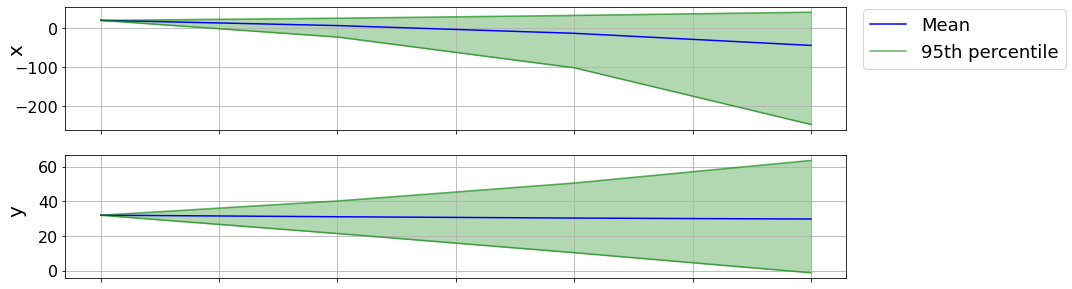

In [35]:
# Plot trajectory results
plt.figure(figsize=(14, 5))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(t_test, x_test_sim_mean[:, i], 'b', label='Mean')
    plt.plot(t_test, bottom_line[:, i], 'g', alpha=0.6, label='95th percentile')
    plt.plot(t_test, top_line[:, i], 'g', alpha=0.6)
    ax = plt.gca()
    ax.fill_between(t_test, bottom_line[:, i], top_line[:, i], color='g', alpha=0.3)
    plt.grid(True)
    if i != 2:
        ax.set_xticklabels([])
    else:
        plt.xlabel('t', fontsize=20)
    plt.ylabel(feature_names[i], fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.set_label_coords(-0.05, 0.75 - 0.1 * (i + 1))
    if i == 0:
        ax.legend(bbox_to_anchor=(1.01, 1.05), fontsize=18)